# London Smart meters dataset

https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households

## Transform extracting features with TSFEL

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
import tsfel

In [3]:

DATASET_ID = 2 # 'FULL'

#domain = "statistical"
domain = "temporal"
#domain = "spectral"
#domain = None   # none means all the features

DECIMATION_RATE = 0.1 # valid only if dataset is FULL

In [4]:
dataset_root = Path('../../Dataset')

In [5]:
if isinstance( DATASET_ID, int )  :
    dataset = sorted(list((dataset_root/'partitioned/Small LCL Data').glob('*.csv')))[ DATASET_ID ]
else :
    dataset = dataset_root/'full/CC_LCL-FullData.csv'

In [6]:
%%time
df = pd.read_csv(dataset, names = ['ID','type','timestamp','consumption'], header = 0) 

CPU times: user 409 ms, sys: 50.6 ms, total: 459 ms
Wall time: 459 ms


In [7]:
ids = df.ID.unique()
if not isinstance( DATASET_ID, int )  :
    ids = np.random.choice( ids, int( len(ids) * DECIMATION_RATE ) )
    df = df.query( 'ID in @ids' )

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   ID           1000000 non-null  object
 1   type         1000000 non-null  object
 2   timestamp    1000000 non-null  object
 3   consumption  1000000 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


In [9]:
%%time
df = (df
      .assign( timestamp = pd.to_datetime(df.timestamp) )
      .assign( consumption = pd.to_numeric( df.consumption, errors = 'coerce' ) )
      .assign( invalid = lambda x : x.consumption.isna() )
#      .assign( consumption = lambda x : x.consumption.fillna( -1.0 ) )
    )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   ID           1000000 non-null  object        
 1   type         1000000 non-null  object        
 2   timestamp    1000000 non-null  datetime64[ns]
 3   consumption  999970 non-null   float64       
 4   invalid      1000000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), object(2)
memory usage: 31.5+ MB
CPU times: user 398 ms, sys: 16 ms, total: 414 ms
Wall time: 412 ms


In [10]:
df.tail()

,ID,type,timestamp,consumption,invalid
999995,MAC000363,Std,2012-04-06 16:00:00,0.081,False
999996,MAC000363,Std,2012-04-06 16:30:00,0.108,False
999997,MAC000363,Std,2012-04-06 17:00:00,0.070,False
999998,MAC000363,Std,2012-04-06 17:30:00,0.071,False
999999,MAC000363,Std,2012-04-06 18:00:00,0.069,False


In [11]:
%%time
df_series = (  df
               .assign( year = df.timestamp.dt.year.astype( str ) )
               .assign( month = df.timestamp.dt.month.apply( lambda d : f'{d:02d}' ) ) 
               .assign( day = df.timestamp.dt.day.apply( lambda d : f'{d:02d}' ) ) 
               .assign( time = df.timestamp.dt.time.astype( str ) )
               .assign( year_month = lambda x : x.year.str.cat( x.month, sep = '-' ) )
               .assign( day_time = lambda x : x.day.str.cat( x.time, sep = '-' ) )
               .assign( sample_name = lambda x : x.ID.str.cat( x.year_month, sep = '-' ) )
               [['sample_name','day_time','consumption']]
               .groupby( ['sample_name','day_time'] )
               .sum()
               .unstack( 'day_time' )
               .droplevel(0, axis = 1)
            )


CPU times: user 2.96 s, sys: 388 ms, total: 3.34 s
Wall time: 3.34 s


In [12]:
# build a dataframe as required by tsfel to extract features:
# rows are timestamps and columns are series names
X = df_series.T.fillna(0)

# uncomment the following to reduce the samples to a subset, to explore results
# choosen_idxs = np.random.choice(len(df_series), size = 15, replace = False)
# X = df_series.iloc[choosen_idxs].T.droplevel(0).fillna(0)

In [13]:
X.head()

sample_name,MAC000326-2012-04,MAC000326-2012-05,MAC000326-2012-06,MAC000326-2012-07,MAC000326-2012-08,MAC000326-2012-09,MAC000326-2012-10,MAC000326-2012-11,MAC000326-2012-12,MAC000326-2013-01,...,MAC000362-2013-07,MAC000362-2013-08,MAC000362-2013-09,MAC000362-2013-10,MAC000362-2013-11,MAC000362-2013-12,MAC000362-2014-01,MAC000362-2014-02,MAC000363-2012-03,MAC000363-2012-04
day_time,,,,,,,,,,,,,,,,,,,,,
01-00:00:00,0.0,0.100,0.119,0.393,0.074,0.146,0.041,0.840,1.666,0.168,...,0.084,0.018,0.040,0.019,0.019,0.143,0.062,0.119,0.0,0.261
01-00:30:00,0.0,0.247,0.096,0.087,0.050,0.052,0.062,1.195,1.527,0.195,...,0.019,0.025,0.063,0.057,0.064,0.043,0.022,0.153,0.0,0.311
01-01:00:00,0.0,0.837,0.095,0.060,0.055,0.064,0.029,0.188,0.796,0.791,...,0.060,0.063,0.060,0.058,0.053,0.020,0.018,0.171,0.0,0.035
01-01:30:00,0.0,0.119,0.079,0.045,0.049,0.032,0.073,0.046,0.261,0.603,...,0.059,0.061,0.034,0.018,0.019,0.019,0.032,0.068,0.0,0.034
01-02:00:00,0.0,0.096,0.093,0.061,0.056,0.068,0.030,0.052,0.248,0.148,...,0.019,0.022,0.030,0.019,0.019,0.054,0.062,0.020,0.0,0.033


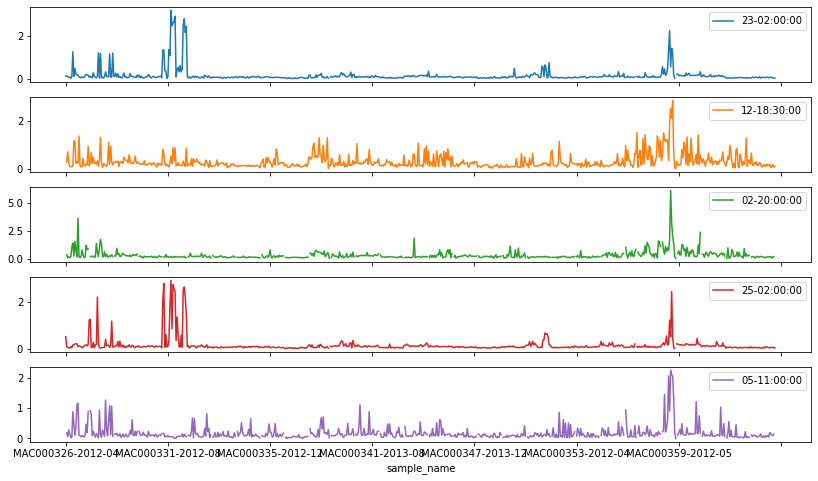

In [14]:
# Show some ranomd series
df_series.T.sample(5).T.plot( figsize = (14,8), subplots = True )
plt.show()

In [15]:
# synthetic dataset used to check columns ordering
# X = pd.concat([pd.Series([0]*10) for _ in range(10)] + [pd.Series([10]*10) for _ in range(2)], axis = 1)
# X.columns = [f'serie_{x}' for x in range(12)]
# X

In [16]:
# build config file to drive tsfel 

#cfg_file = tsfel.get_features_by_domain()               # All features will be extracted.
#cfg_file = tsfel.get_features_by_domain("statistical")  # All statistical domain features will be extracted
#cfg_file = tsfel.get_features_by_domain("temporal")     # All temporal domain features will be extracted
#cfg_file = tsfel.get_features_by_domain("spectral")     # All spectral domain features will be extracted



cfg_file = tsfel.get_features_by_domain(domain)               


In [17]:
# Xf is the feature extraction dataset from tsfel
# it is a single row of features with feature names in the format f'{s}_{name}' 
# where 's' is the column number in the original dataset and 'name' is the feature name.
# Feratures are orederd in alphabetical order thus features of column #11 come after 
# features of column #1
# This is beacuse tsfel is designed with multivariate ts in mind, not multiple ts.

Xf = tsfel.time_series_features_extractor(cfg_file, X ) 

*** Feature extraction started ***
26


/tmp/ipykernel_86926/3264033782.py:8: UserWarning: Using default sampling frequency set in configuration file.
  Xf = tsfel.time_series_features_extractor(cfg_file, X )



*** Feature extraction finished ***


In [18]:
Xf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 233856 entries, 0_FFT mean coefficient_0 to 9_Wavelet variance_8
dtypes: float64(233856)
memory usage: 1.8 MB


In [19]:
# Convert the features row in a features table with time series in the rows and relevent features in the columns
df_features = ( Xf
  .T    # Transpose to have the columns as index
  .set_index( pd.MultiIndex.from_tuples( \
      [(int(i),s) for i,s in [re.match(r'(\d+)_(.+)',idx).groups() for idx in Xf.columns]]
   ))  # build a mulitindex from the current index
  .T   # Set the index back on the columns
  .stack(0)     # Level 0 of multiindex columns is the time series number in the order of the original dataset
  .droplevel(0) # index level 0 is just '0' because Xf had only one row
  .sort_index() # probably useless but there is noguarantee about column order from tsfel
  .set_index(X.columns) # rename the index as the names of the time series
)

In [20]:
df_features

,FFT mean coefficient_0,FFT mean coefficient_1,FFT mean coefficient_10,FFT mean coefficient_100,FFT mean coefficient_101,FFT mean coefficient_102,FFT mean coefficient_103,FFT mean coefficient_104,FFT mean coefficient_105,FFT mean coefficient_106,...,Wavelet standard deviation_8,Wavelet variance_0,Wavelet variance_1,Wavelet variance_2,Wavelet variance_3,Wavelet variance_4,Wavelet variance_5,Wavelet variance_6,Wavelet variance_7,Wavelet variance_8
sample_name,,,,,,,,,,,,,,,,,,,,,
MAC000326-2012-04,1.457189e-03,0.076940,0.023532,0.000250,0.000401,0.000591,1.354448e-03,0.000925,0.000537,0.002528,...,0.731537,0.040929,0.124789,0.236246,0.352769,0.471494,0.555129,0.578698,0.561428,0.535146
MAC000326-2012-05,7.319612e-04,0.092085,0.035097,0.000762,0.001419,0.001354,8.032253e-04,0.000553,0.002513,0.001574,...,1.094456,0.067121,0.206657,0.411308,0.657844,0.915096,1.109727,1.202740,1.215836,1.197834
MAC000326-2012-06,2.826330e-04,0.069896,0.025818,0.001833,0.000759,0.000520,7.062129e-04,0.001660,0.001803,0.000801,...,0.829631,0.040583,0.126478,0.247535,0.378042,0.502341,0.594513,0.647495,0.673242,0.688287
MAC000326-2012-07,7.843361e-05,0.003325,0.001550,0.001153,0.000201,0.000045,3.186457e-04,0.000190,0.000180,0.000162,...,0.405923,0.016306,0.044859,0.086941,0.127073,0.162649,0.185200,0.188938,0.178795,0.164773
MAC000326-2012-08,3.360939e-05,0.004392,0.002889,0.000113,0.000249,0.000252,1.151686e-04,0.000173,0.000113,0.000170,...,0.382733,0.011787,0.034152,0.065215,0.100815,0.133471,0.153874,0.158535,0.153270,0.146485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAC000362-2013-12,2.826940e-07,0.000329,0.001249,0.000145,0.000023,0.000046,5.477276e-05,0.000047,0.000089,0.000107,...,0.159218,0.003881,0.006265,0.009709,0.013659,0.017521,0.020537,0.022489,0.023903,0.025350
MAC000362-2014-01,1.976332e-06,0.000316,0.001163,0.000044,0.000056,0.000075,1.285269e-05,0.000077,0.000033,0.000019,...,0.146706,0.003449,0.005210,0.007747,0.010369,0.013109,0.015600,0.017666,0.019536,0.021523
MAC000362-2014-02,5.018650e-05,0.001624,0.000489,0.000050,0.000025,0.000075,2.787613e-05,0.000064,0.000053,0.000185,...,0.128323,0.003868,0.005505,0.009020,0.012693,0.015399,0.016804,0.017027,0.016694,0.016467


# Save ingested data

In [21]:
if domain is None :
    domain = 'all'
    
if isinstance( DATASET_ID, int )  :
    out_file_series = f'ingested/series_{DATASET_ID}.csv' 
    out_file_features = f'ingested/fsfel_{domain}_features_{DATASET_ID}.csv' 
else :
    out_file_series = f'ingested/series_full_{DECIMATION_RATE}.csv' 
    out_file_features = f'ingested/fsfel_features_full_{DECIMATION_RATE}.csv' 
    
df_series.to_csv( dataset_root/out_file_series )
print(f'Series dataframe saved to {dataset_root/out_file_series}')

df_features.to_csv( dataset_root/out_file_features )
print(f'Features dataframe saved to {dataset_root/out_file_features}')


Series dataframe saved to ../../Dataset/ingested/series_2.csv
Features dataframe saved to ../../Dataset/ingested/fsfel_spectral_features_2.csv
